# Chlorophyll A Data Vis Workbook
### Amy Phung, August 2020

This notebook provides some minor revisions to the original figures presented in the extended abstract notebook. Notably:
+ At the time of writing, the original flow-through data did not have a fully up-to-date satellite dataset as a basis of comparison. The data was compared to the most recent data at the time as a stand-in. In this notebook, this figure is updated using currently available data.
+ The .nc files are now directly used (significant time & space improvement over converting data to a csv)
+ Outliers are now marked in a clearer format & are removed for analysis

## Setup

In [87]:
from netCDF4 import Dataset
import numpy as np
import pandas as pd
import glob
import datetime
from pandarallel import pandarallel
import scipy
import scipy.stats
import scipy.odr
pandarallel.initialize()

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


## BGC Argo
The satellite data for the BGC Argo comparison was fully up-to-date in the original, so the original results are loaded here

In [88]:
compiled_results = pd.read_csv('data/compiled-data/3-31results2.csv', index_col=0)
compiled_results.head()

,Src,Lat,Long,Chl-A,Timestamp,Station,Sat Chl-A,Sat Lat,Sat Long,Sat File
0,BGC,-32.465,185.24200,0.598395,1.501384e+09,1,0.220572,-32.479168,185.270828,data/satellite-data/autogenerated-csv\V2017209...
1,BGC,-32.267,185.30000,0.628195,1.502250e+09,2,0.276144,-32.270832,185.312500,data/satellite-data/autogenerated-csv\V2017217...
2,BGC,-32.298,185.25600,0.415293,1.503110e+09,3,0.211113,-32.312500,185.270828,data/satellite-data/autogenerated-csv\V2017225...
3,BGC,-32.560,185.32600,0.514820,1.503982e+09,4,0.181649,-32.562500,185.395828,data/satellite-data/autogenerated-csv\V2017233...
4,BGC,-32.979,185.25101,0.363909,1.504851e+09,5,0.204564,-32.979168,185.270828,data/satellite-data/autogenerated-csv\V2017249...


## Satellite Data Update
Fully up-to-date satellite data was not available when creating the original figures, so those figures are updated here

#### Satellite Data Class

In [89]:
class SatelliteDataset():
    def __init__(self, directory):
        self.lookup_df = self._createLookupTable(directory)
        
    def _parseTimestamps(self, files):
        ts_starts, ts_ends = [], []

        for f in files:
            # Parse filename to find date
            start_idx = f.find("V") + 1 
            year_st  = int(f[start_idx:start_idx + 4]) # Year is 4 chars long 
            day_st   = int(f[start_idx + 4:start_idx + 7]) # Day is 3 chars long
            year_end = int(f[start_idx + 7:start_idx + 11]) 
            day_end  = int(f[start_idx + 11:start_idx + 14]) 

            # Convert from date to timestamp
            time_st = datetime.datetime(year_st, 1, 1) \
                      + datetime.timedelta(day_st - 1)
            time_end = datetime.datetime(year_end, 1, 1) \
                      + datetime.timedelta(day_end)
        
            # Add to output array
            ts_starts.append(time_st.timestamp())
            ts_ends.append(time_end.timestamp())
            
        return ts_starts, ts_ends
    
    def _createLookupTable(self, directory):
        """ Creates lookup table for finding appropriate file by time """
        file_list = glob.glob('%s/*.nc' % directory)
        ts_starts, ts_ends = self._parseTimestamps(file_list)
        
        l_df = pd.DataFrame([file_list, ts_starts, ts_ends]).T
        l_df.columns=["Filename", "Time Start", "Time End"]
        l_df = l_df.sort_values(by=["Time Start"])
        l_df.reset_index(inplace=True, drop=True)
        return l_df
    
    def findBestFile(self, timestamp):
        """For a given timestamp, finds the best satellite data file"""

        valid_st = self.lookup_df[(timestamp >= self.lookup_df["Time Start"])]
        if len(valid_st) == 0: # Timestamp is earlier than available data
            print("Warning: Timestamp is earlier than available data. Using first available file")
            return str(self.lookup_df.iloc[0]["Filename"])
        
        valid_end = valid_st[timestamp < valid_st["Time End"]]
        if len(valid_end) == 0: # Timestamp is later than available data
            print("Warning: Timestamp is later than available data. Using last available file")
            return str(self.lookup_df.iloc[-1]["Filename"])
        return str(valid_end.iloc[-1]["Filename"])

In [90]:
# Initialize satellite dataset
sat_data = SatelliteDataset('data/satellite-data')

In [91]:
# Create list of new satellite files
new_sat_list = compiled_results[compiled_results["Src"] == "FT"]["Timestamp"].parallel_apply(sat_data.findBestFile)

#### Compute new chl-a, lats, long values for all flow-through points

In [92]:
def lookupChlorophyll(df_row, lons, lats, chls):
    """ Looks up nearest satellite point for each flow-through 
    point and returns the corresponding chlorophyll value """
    
    lon_idx = abs(lons-df_row["Long"]).argmin()
    lat_idx = abs(lats-df_row["Lat"]).argmin()
    
    # Check if data is invalid
    if chls.mask[lat_idx][lon_idx] == True:
        return np.nan

    chl_val = chls[lat_idx][lon_idx]
    return chl_val

temp_sat_list = []

for f in new_sat_list.unique():
    fh = Dataset(f, mode='r')
    lons = fh.variables['lon'][:]
    lats = fh.variables['lat'][:]
    chls = fh.variables['chlor_a'][:]
    fh.close()

    # Extract flow-through data with current sat file name
    new_sat_df = compiled_results[compiled_results["Src"] == "FT"] \
                                 [new_sat_list == f] \
                                 .parallel_apply(lookupChlorophyll, axis=1, args=(lons,lats,chls,))
    temp_sat_list.append(new_sat_df)
    
new_sat_data = pd.concat(temp_sat_list)

In [93]:
# Update dataframe
compiled_results.insert(10, "New Sat Chl-A", new_sat_data)

#### Separate Outliers - FT

In [94]:
ft_pts = compiled_results.dropna()

In [95]:
ft_sat_z_scores = scipy.stats.zscore(ft_pts["New Sat Chl-A"])
ft_sat_abs_z_scores = np.abs(ft_sat_z_scores)
ft_sat_filter = ft_sat_abs_z_scores < 3

ft_sat_outliers = ft_pts[~ft_sat_filter]

filtered_ft_pts = ft_pts[ft_sat_filter]

#### Separate Outliers - BGC

In [96]:
bgc_pts = compiled_results[compiled_results["Src"]=="BGC"]

In [97]:
bgc_z_scores = scipy.stats.zscore(bgc_pts["Chl-A"])
bgc_abs_z_scores = np.abs(bgc_z_scores)
bgc_filter = bgc_abs_z_scores < 3

bgc_sat_z_scores = scipy.stats.zscore(bgc_pts["Sat Chl-A"])
bgc_sat_abs_z_scores = np.abs(bgc_sat_z_scores)
bgc_sat_filter = bgc_sat_abs_z_scores < 3

bgc_outliers = bgc_pts[~bgc_filter]
bgc_sat_outliers = bgc_pts[~bgc_sat_filter]

filtered_bgc_pts = bgc_pts[bgc_filter & bgc_sat_filter]

## Update Figures

#### Setup

In [98]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
# import seaborn as sns
# from jupyterthemes import jtplot
# import cartopy.feature
# import cartopy.crs as ccrs
from sklearn.mixture import GaussianMixture
from matplotlib.ticker import PercentFormatter
from matplotlib.legend_handler import HandlerLine2D

In [99]:
# Uncomment for white-background figures
mpl.rcParams['figure.facecolor'] = 'white'

# Make graphs appear larger
plt.rcParams['figure.dpi'] = 200

# Change font
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'

### Flow-through

#### Flow-through vs Satellite Data by station

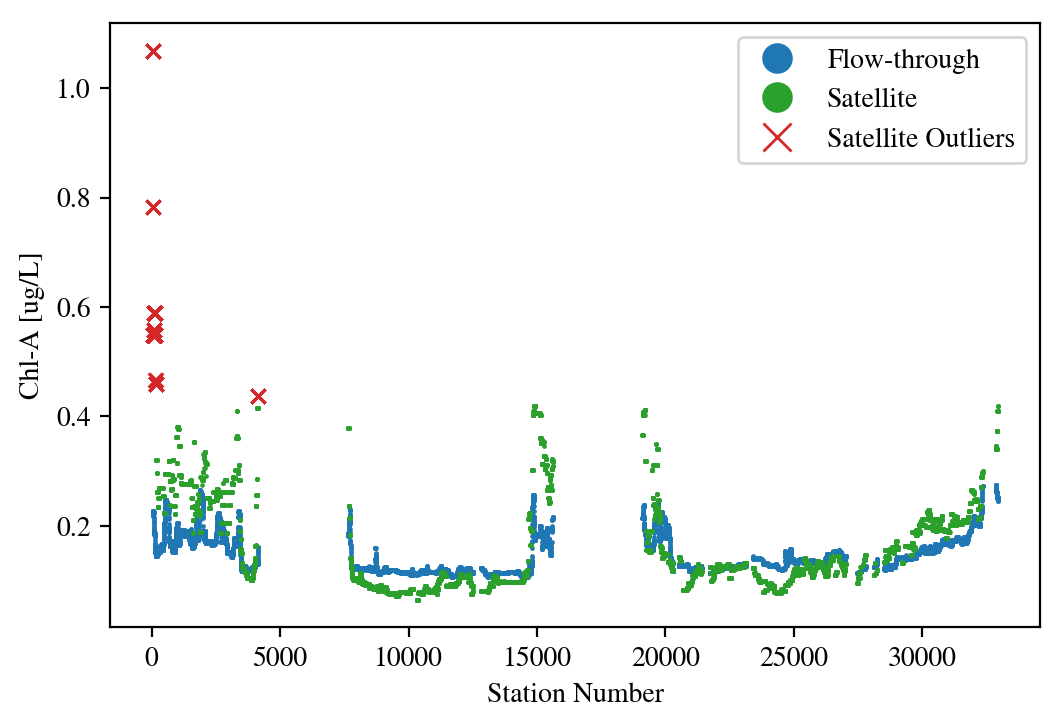

In [100]:
plt.plot(ft_pts["Station"],
         ft_pts["Chl-A"], 
         'o', c="tab:blue", markersize=0.7, label="Flow-through")

plt.plot(ft_pts["Station"],
         ft_pts["New Sat Chl-A"], 
         'o', c="tab:green", markersize=0.7, label="Satellite")

plt.plot(ft_sat_outliers["Station"],
         ft_sat_outliers["New Sat Chl-A"], 
         'x', c="tab:red", markersize=5, label="Satellite Outliers")


plt.xlabel("Station Number")
plt.ylabel("Chl-A [ug/L]")

def update_prop(handle, orig):
    handle.update_from(orig)
    handle.set_markersize(10)

plt.legend(handler_map={plt.Line2D:HandlerLine2D(update_func=update_prop)})

In [101]:
class BestFitLine:
    def __init__(self, x, y):
        self.slope, self.intercept, self.r_value, self.p_value, \
            self.std_err = scipy.stats.linregress(x, y)
    
    def computeY(self, x):
        return self.intercept + self.slope*x

p-value 0: 0.0
r-value 0: 0.4888074568026721
p-value 1: 0.0
r-value 1: 0.3881066463286373


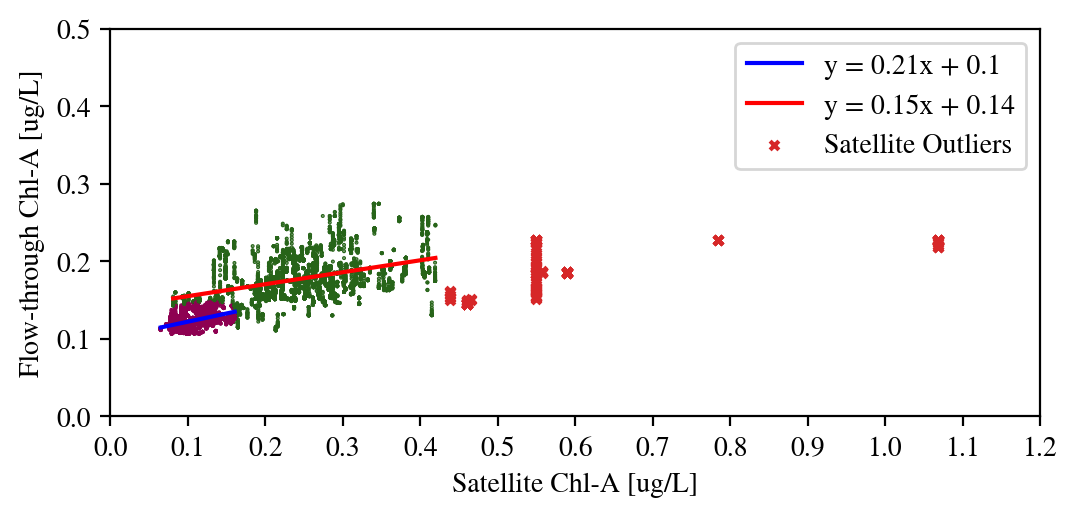

In [67]:
x = filtered_ft_pts["New Sat Chl-A"]
y = filtered_ft_pts["Chl-A"]

X = np.array(list(zip(x,y)))

# Cluster data
gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=42)
labels = gmm.fit(X).predict(X)


# Compute and plot best fit lines for cluster 0
x0 = x[labels == 0]
y0 = y[labels == 0]

ft_sat_line0 = BestFitLine(x0, y0)
print("p-value 0: " + str(ft_sat_line0.p_value))
print("r-value 0: " + str(ft_sat_line0.r_value))
eq0= "y = " + str(round(ft_sat_line0.slope,2)) + \
      "x + " + str(round(ft_sat_line0.intercept,2))

xp = np.linspace(x0.min(), x0.max(), 100)
plt.plot(xp, ft_sat_line0.computeY(xp), 'b-', label=eq0)

# Compute and plot best fit lines for cluster 1
x1 = x[labels == 1]
y1 = y[labels == 1]

ft_sat_line1 = BestFitLine(x1, y1)
print("p-value 1: " + str(ft_sat_line1.p_value))
print("r-value 1: " + str(ft_sat_line1.r_value))
eq1 = "y = " + str(round(ft_sat_line1.slope,2)) + \
      "x + " + str(round(ft_sat_line1.intercept,2))

xp = np.linspace(x1.min(), x1.max(), 100)
plt.plot(xp, ft_sat_line1.computeY(xp), 'r-', label=eq1)

# Plot Clusters
plt.scatter(X[:, 0], X[:, 1], c=labels, s=0.2, cmap='PiYG', zorder=2)

plt.axis("equal")

plt.xlabel("Satellite Chl-A [ug/L]")
plt.ylabel("Flow-through Chl-A [ug/L]")

plt.scatter(ft_sat_outliers["New Sat Chl-A"],
            ft_sat_outliers["Chl-A"], 
            s=10, c="tab:red", marker='x', label="Satellite Outliers")

major_ticks = np.arange(0, 1.5, 0.1)
plt.xticks(major_ticks)
plt.yticks(major_ticks)
plt.xlim([0,1.2])
plt.ylim([0,0.5])
plt.legend()

plt.gca().set_aspect('equal', adjustable='box')

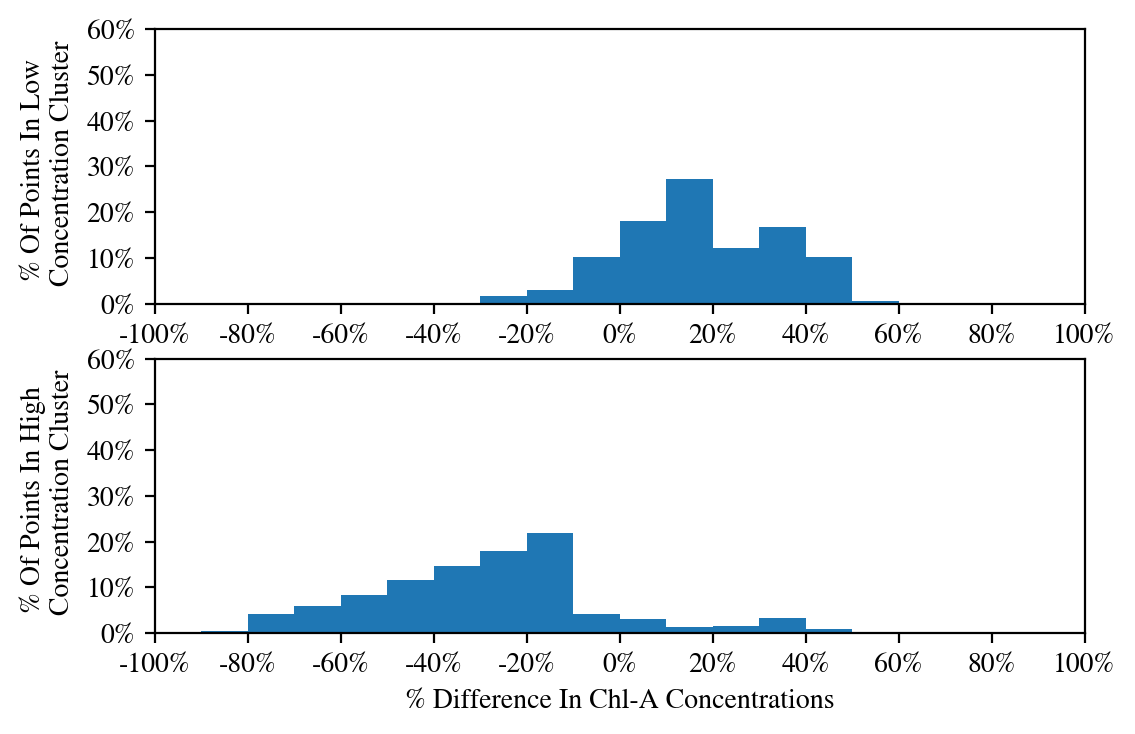

Cluster 1 mean: 17.63045715664549%
Cluster 2 mean: -28.186770211482504%
Overall mean: -0.49748127578988366%


In [68]:
data0 = (y0-x0)/((y0+x0)/2)*100
data1 = (y1-x1)/((y1+x1)/2)*100
n_bins = 10

# Include values greater or less than 100 percent in 100 percent bin
bins = np.arange(-100,101,n_bins)
bins[0] = -1000
bins[-1] = 1000

# Create two subplots sharing y axis
fig, (ax0, ax1) = plt.subplots(2, sharey=True)

ax0.hist(data0, weights=np.ones(len(data0)) / len(data0),
         bins=bins)
ax0.set(ylabel='% Of Points In Low \n Concentration Cluster')
ax0.yaxis.set_major_formatter(PercentFormatter(1))
ax0.xaxis.set_major_formatter(PercentFormatter(100))
ax0.set_xlim([-100,100])

ax1.hist(data1, weights=np.ones(len(data1)) / len(data1),
         bins=bins)
ax1.set(xlabel='% Difference In Chl-A Concentrations',
        ylabel='% Of Points In High \n Concentration Cluster')
ax1.yaxis.set_major_formatter(PercentFormatter(1))
ax1.xaxis.set_major_formatter(PercentFormatter(100))
ax1.set_xlim([-100,100])

# Adjust ticks
x_ticks = np.arange(-100, 101, 20) 
y_ticks = np.arange(0, 0.61, 0.1)
ax0.set_xticks(x_ticks)
ax0.set_yticks(y_ticks)
ax1.set_xticks(x_ticks)
ax1.set_yticks(y_ticks)

plt.show()

print("Cluster 1 mean: " + str(data0.mean()) + "%")
print("Cluster 2 mean: " + str(data1.mean()) + "%")
print("Overall mean: " + str(np.append(data0, data1).mean()) + "%")

### Biogeochemical Argo

#### BGC Argo vs Satellite Data

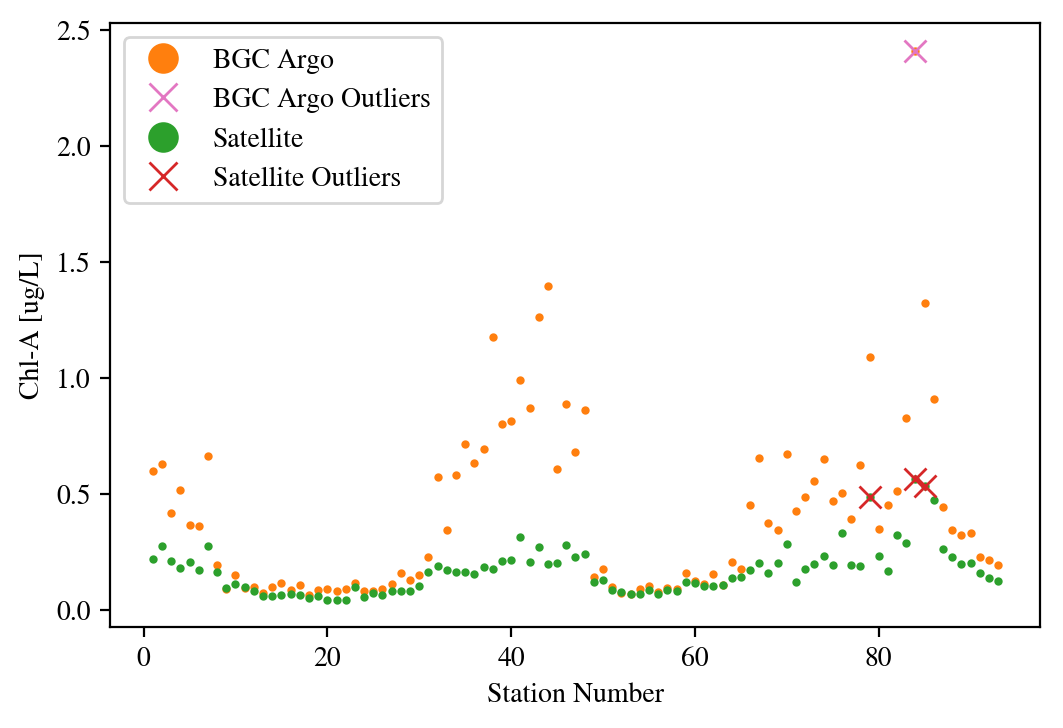

In [72]:
plt.plot(bgc_pts["Station"],
         bgc_pts["Chl-A"], 
         'o', c="tab:orange", markersize=2, label="BGC Argo")

plt.plot(bgc_outliers["Station"],
         bgc_outliers["Chl-A"], 
         'x', c="tab:pink", markersize=8, label="BGC Argo Outliers")

plt.plot(bgc_pts["Station"],
         bgc_pts["Sat Chl-A"], 
         'o', c="tab:green", markersize=2, label="Satellite")

plt.plot(bgc_sat_outliers["Station"],
         bgc_sat_outliers["Sat Chl-A"], 
         'x', c="tab:red", markersize=8, label="Satellite Outliers")


plt.xlabel("Station Number")
plt.ylabel("Chl-A [ug/L]")
plt.legend()

def update_prop(handle, orig):
    handle.update_from(orig)
    handle.set_markersize(10)

plt.legend(handler_map={plt.Line2D:HandlerLine2D(update_func=update_prop)})

p-value 0: 0.03744918241974715
r-value 0: 0.3077810216403913
p-value 1: 3.5410462733602857e-15
r-value 1: 0.8801591496271743


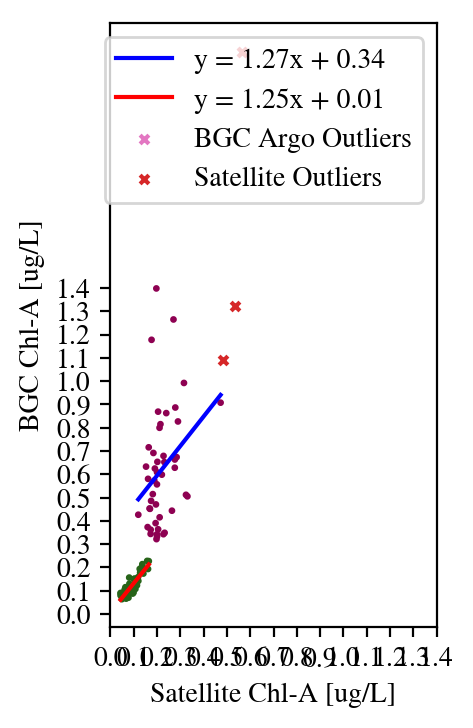

In [102]:
x = filtered_bgc_pts["Sat Chl-A"]
y = filtered_bgc_pts["Chl-A"]
X = np.array(list(zip(x,y)))

# Cluster data
gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=42)
labels = gmm.fit(X).predict(X)

# Compute and plot best fit lines for cluster 0
x0 = x[labels == 0]
y0 = y[labels == 0]

bgc_sat_line0 = BestFitLine(x0, y0)
print("p-value 0: " + str(bgc_sat_line0.p_value))
print("r-value 0: " + str(bgc_sat_line0.r_value))
eq0= "y = " + str(round(bgc_sat_line0.slope,2)) + \
      "x + " + str(round(bgc_sat_line0.intercept,2))

xp = np.linspace(x0.min(), x0.max(), 100)
plt.plot(xp, bgc_sat_line0.computeY(xp), 'b-', label=eq0)

# Compute and plot best fit lines for cluster 1
x1 = x[labels == 1]
y1 = y[labels == 1]

bgc_sat_line1 = BestFitLine(x1, y1)
print("p-value 1: " + str(bgc_sat_line1.p_value))
print("r-value 1: " + str(bgc_sat_line1.r_value))
eq1 = "y = " + str(round(bgc_sat_line1.slope,2)) + \
      "x + " + str(round(bgc_sat_line1.intercept,2))

xp = np.linspace(x1.min(), x1.max(), 100)
plt.plot(xp, bgc_sat_line1.computeY(xp), 'r-', label=eq1)



# Plot Clusters
plt.scatter(X[:, 0], X[:, 1], c=labels, s=2, cmap='PiYG', zorder=2)

plt.axis("equal")

plt.xlabel("Satellite Chl-A [ug/L]")
plt.ylabel("BGC Chl-A [ug/L]")

plt.scatter(bgc_outliers["Sat Chl-A"],
            bgc_outliers["Chl-A"], 
            s=10, c="tab:pink", marker='x', label="BGC Argo Outliers")

plt.scatter(bgc_sat_outliers["Sat Chl-A"],
            bgc_sat_outliers["Chl-A"], 
            s=10, c="tab:red", marker='x', label="Satellite Outliers")

major_ticks = np.arange(0, 1.5, 0.1)
plt.xticks(major_ticks)
plt.yticks(major_ticks)
# plt.xlim([0,2])
# plt.ylim([0,2])
plt.legend()

plt.gca().set_aspect('equal', adjustable='box')

p-value 0: 0.03744918241974715
r-value 0: 0.3077810216403913


<module 'scipy.odr' from '/home/amy/.local/lib/python3.5/site-packages/scipy/odr/__init__.py'>

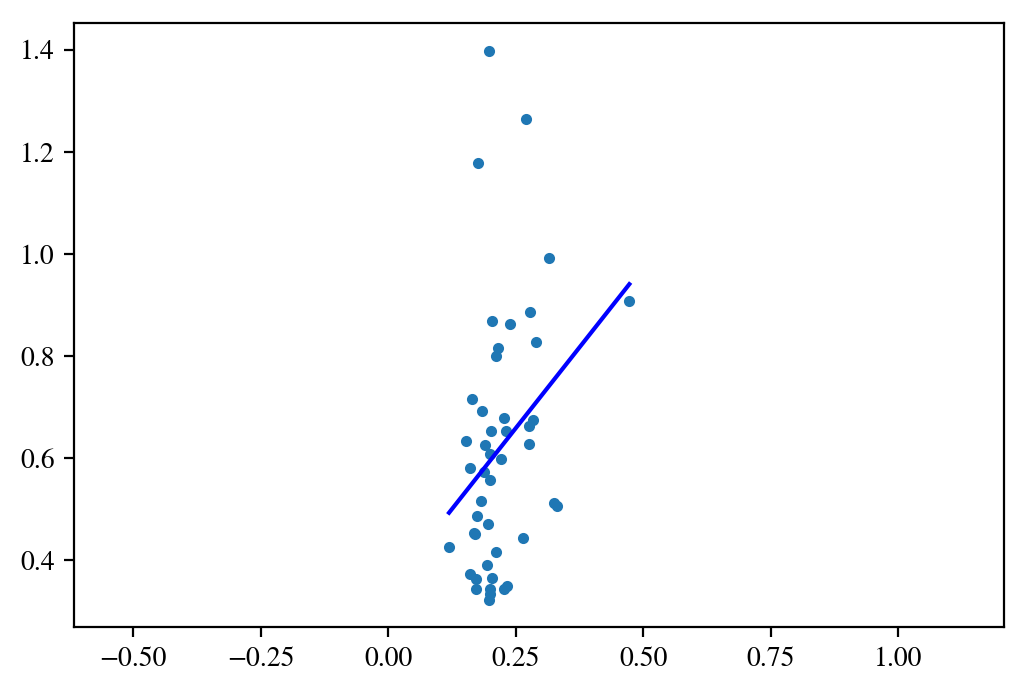

In [103]:
plt.plot(x0,y0, '.')
plt.axis('equal')

bgc_sat_line0 = BestFitLine(x0, y0)
print("p-value 0: " + str(bgc_sat_line0.p_value))
print("r-value 0: " + str(bgc_sat_line0.r_value))
eq0= "y = " + str(round(bgc_sat_line0.slope,2)) + \
      "x + " + str(round(bgc_sat_line0.intercept,2))

xp = np.linspace(x0.min(), x0.max(), 100)
plt.plot(xp, bgc_sat_line0.computeY(xp), 'b-', label=eq0)



Beta: [12.67314129 -2.16939002]
Beta Std Error: [5.59462511 1.23641774]
Beta Covariance: [[ 9095.59183023 -2002.17066894]
 [-2002.17066894   444.24182131]]
Residual Variance: 0.0034412087418321928
Inverse Condition #: 0.0019267006373780255
Reason(s) for Halting:
  Sum of squares convergence


(0.021843374000000002, 0.494301426, -1.8925658595910946, 4.0949617862216545)

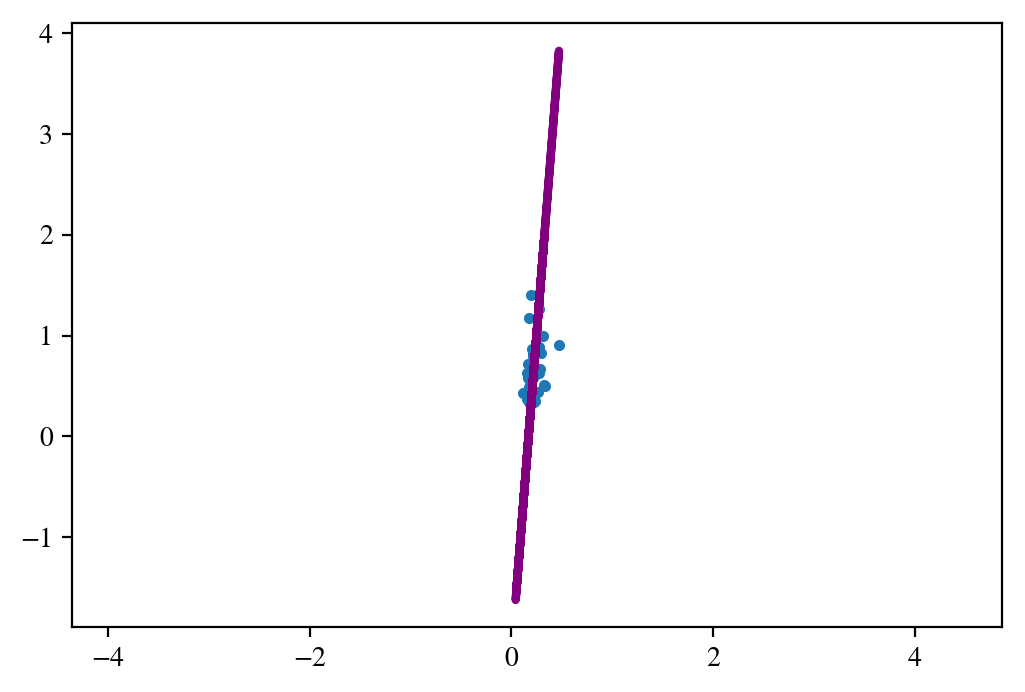

In [125]:
def linear_func(p, x):
    m, c = p
    return m*x + c

def line(x, a):
    """The line of best fit."""
    # unpack the parameters:
    y = a*x
    return y

linear_model = scipy.odr.Model(linear_func)

data = scipy.odr.RealData(x0, y0)
odr = scipy.odr.ODR(data, linear_model, beta0=[0., 1.])
regression = odr.run()
regression.pprint()
plt.plot(x0, y0, '.')
plt.plot(x, linear_func((regression.beta), x), label='ODR', lw=3, color='purple')
plt.axis('equal')

array([0.59856549, 0.6325392 , 0.41585427, 0.51245526, 0.36427516,
       0.3598744 , 0.66756615, 0.5710051 , 0.34195617, 0.57607328,
       0.7107875 , 0.6275213 , 0.68829096, 1.17052326, 0.79777301,
       0.81346446, 0.99735369, 0.86617852, 1.2647201 , 1.39135811,
       0.60701865, 0.88958883, 0.67914175, 0.86272074, 0.448795  ,
       0.65170088, 0.37001803, 0.34279265, 0.67835243, 0.41971333,
       0.48303635, 0.55553405, 0.65304165, 0.46956915, 0.51472607,
       0.38966937, 0.62238777, 0.35144791, 0.45027164, 0.52070104,
       0.83102404, 0.92557487, 0.44818567, 0.34502941, 0.32169857,
       0.33346676])

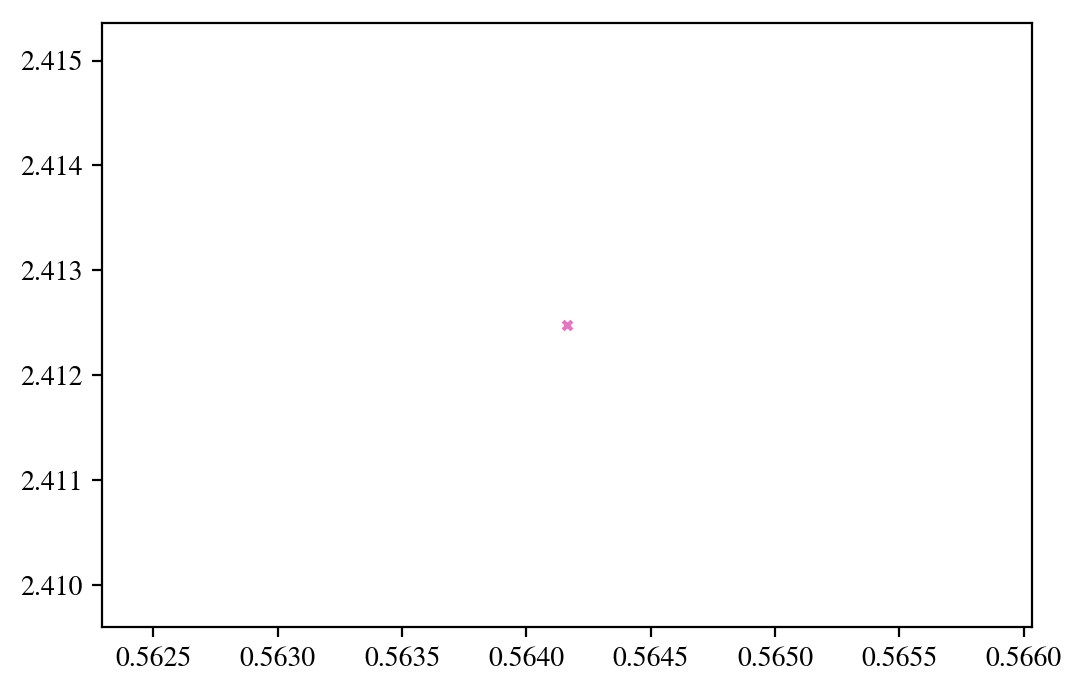

In [79]:
plt.scatter(bgc_outliers["Sat Chl-A"],
            bgc_outliers["Chl-A"], 
            s=10, c="tab:pink", marker='x', label="BGC Argo Outliers")

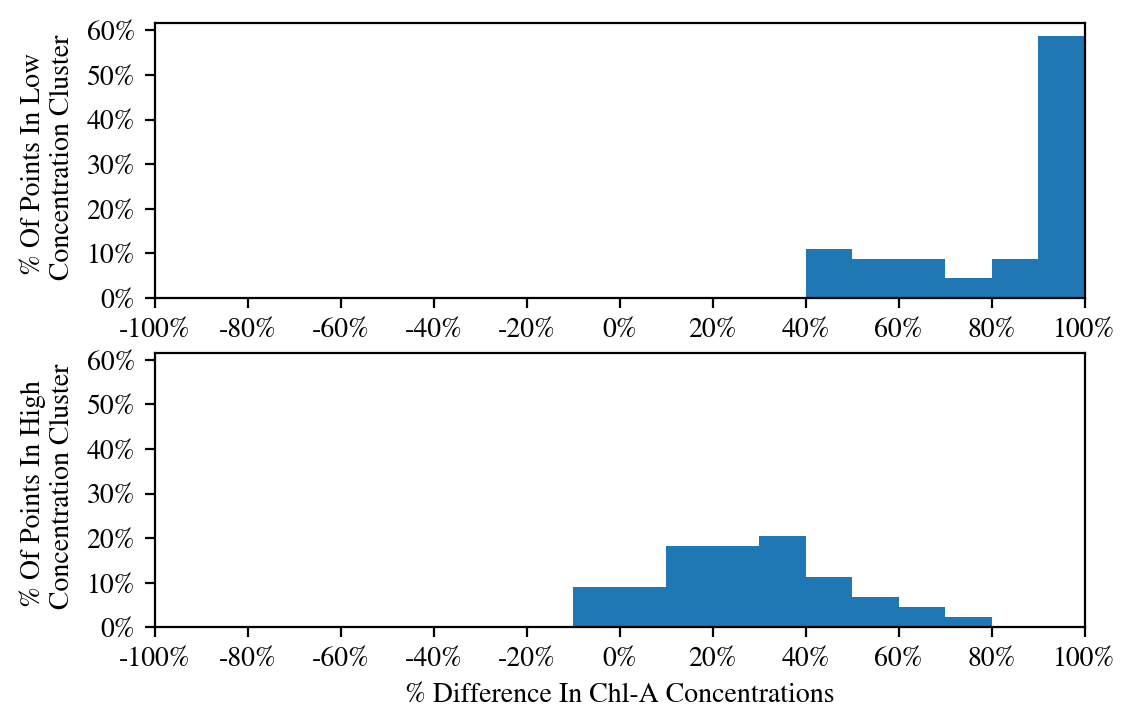

Cluster 1 mean: 89.60517861495443%
Cluster 2 mean: 27.866006592170876%
Overall mean: 59.4215834038158%


In [74]:
data0 = (y0-x0)/((y0+x0)/2)*100
data1 = (y1-x1)/((y1+x1)/2)*100
n_bins = 10

# Include values greater or less than 100 percent in 100 percent bin
bins = np.arange(-100,101,n_bins)
bins[0] = -1000
bins[-1] = 1000

# Create two subplots sharing y axis
fig, (ax0, ax1) = plt.subplots(2, sharey=True)

ax0.hist(data0, weights=np.ones(len(data0)) / len(data0),
         bins=bins)
ax0.set(ylabel='% Of Points In Low \n Concentration Cluster')
ax0.yaxis.set_major_formatter(PercentFormatter(1))
ax0.xaxis.set_major_formatter(PercentFormatter(100))
ax0.set_xlim([-100,100])

ax1.hist(data1, weights=np.ones(len(data1)) / len(data1),
         bins=bins)
ax1.set(xlabel='% Difference In Chl-A Concentrations',
        ylabel='% Of Points In High \n Concentration Cluster')
ax1.yaxis.set_major_formatter(PercentFormatter(1))
ax1.xaxis.set_major_formatter(PercentFormatter(100))
ax1.set_xlim([-100,100])

# Adjust ticks
x_ticks = np.arange(-100, 101, 20) 
y_ticks = np.arange(0, 0.61, 0.1)
ax0.set_xticks(x_ticks)
ax0.set_yticks(y_ticks)
ax1.set_xticks(x_ticks)
ax1.set_yticks(y_ticks)

plt.show()

print("Cluster 1 mean: " + str(data0.mean()) + "%")
print("Cluster 2 mean: " + str(data1.mean()) + "%")
print("Overall mean: " + str(np.append(data0, data1).mean()) + "%")